## This notebook pulls data from PycityLayers, based on proximity to a selected location (my home), and selects the buildings within the radius. Then it creates a graph based on the selected buildings' centroids. This graph is later used in Agent-Based Model (ABM) developed to represent occupants presence within each building.
#### Assumptions are as follows:
1. Each Building is considered as a single node.
2. Nodes are not connected to one another.
3. There is one node defined as "outside node" which is connected to all "building nodes".
4. As things stand, the decision to leave home, or return home, is defined based on the randomly generated integer.
5. There is no implication to occupants' being home or outside.

#### next steps 
1. Add implications of occupants' presence/absence.
2. Improve the movement behavior
3. Figure out the proper visualization of the nodes on the map (currently it is in graph form, but each point contains the coordinates as attributes)
4. Add other attributes to occupants (agents) (currently: only presence) (via DNAS framework)
5. Add attributes to the nodes (currently: none) (examples: envelope characteristics, equipment properties, HVAC spec. etc.) 
6. Add other behavior to occupants (currently: only presence) 

# Setup

In [1]:
from pprint import pprint
from pycitylayers.client import Client
from pycitylayers.utils import PointGQL, PolygonGQL
from shapely.geometry import Polygon, Point, MultiPolygon
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx


## Fetch data from PyCityLayers

In [19]:
client = Client().create(source='cerc')
coll = client.collection
tb=coll[6][0]
print(tb)
query_geometry = PointGQL().point(-73.570552324815,45.530402345761175)
print( query_geometry )

query_options = {
    # 'columns': ['index', 'built_area', 'geom', 'year_built'], 
    'nrows': 10000, 
    'skiprows': 0,
    'geometry_operation': 'distance_from_point',
    'geom_distance': 0.0005,
    'geometry': query_geometry,
    'crs_epsg': 4326,
}

data_lots = tb.query_simple( **query_options )
data_lots.head()

Fetching Metadata. Please Wait ...
---------- Table:0 ----------
Name:		building_lots 
Description:	 
Format:		CSV 

{'geometry': {'type': 'Point', 'coordinates': [-73.570552324815, 45.530402345761175], 'crs': {'type': 'name', 'properties': {'name': 'EPSG:4326'}}}}


,borough_id,building_number,built_area,dwelling_number,firstletter_apt,geom,index,land_area,landuse_code,landuse_text,lastletter_apt,max_floors,municipality_code,nad83_registration,street_name,street_number,uid,unit_category,unit_number,year_built
0,REM21,4218,454,1,0,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",4602,52,1000,Logement,0,1,50,9943-34-1120-6-001-0004,avenue Papineau (MTL),4218,5011916,Condominium,0,1910
1,REM21,4235,219,3,0,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",21512,284,1000,Logement,0,2,50,9943-23-5995-0-000-0000,rue Marquette (MTL),4235,1030537,Régulier,0,1885
2,REM21,4220,362,5,0,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",22960,239,1000,Logement,0,3,50,9943-23-5535-4-000-0000,rue Marquette (MTL),4224,1030019,Régulier,0,1926
3,REM21,1699,1255,16,0,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",23674,644,1000,Logement,0,3,50,9943-34-3605-4-000-0000,rue Rachel Est (MTL),1699,1033787,Régulier,0,1927
4,REM21,1651,466,2,0,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",23781,259,1000,Logement,0,3,50,9943-33-0449-2-000-0000,rue Rachel Est (MTL),1653,1033777,Régulier,0,1915


In [21]:
print("Number of selected buildings:",len(data_lots))

Number of selected buildings: 24


## Find the centroid of the buildings

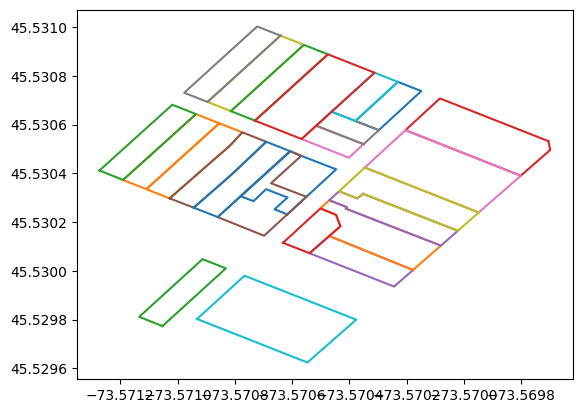

# centroids: 24
# polygons: 24


In [22]:
centroid=[]
for i in range(len(data_lots)):
    vertex = data_lots.iloc[i,:]["geom"]["coordinates"][0]
    polygon1=Polygon(vertex)
    polygon1
    centroid.append(polygon1.centroid)
    plt.plot(*polygon1.exterior.xy)
plt.show()
print("# centroids:",len(centroid))
print("# polygons:",len(data_lots))

## Having extracted the centroids, the graph can be generated. Also, the coordinates of the centroid points are used to plot them. 

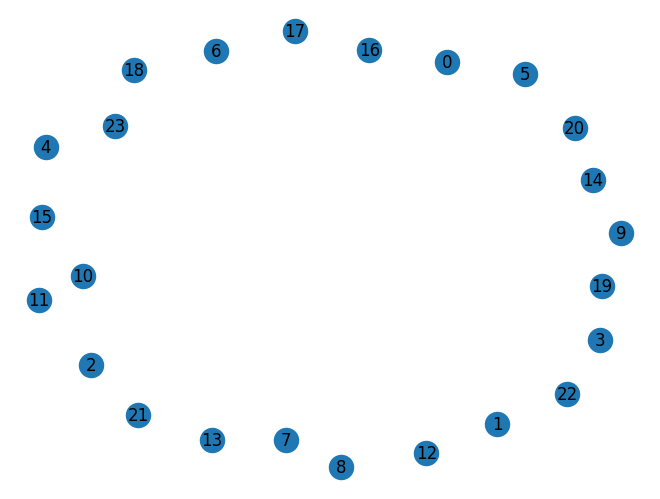

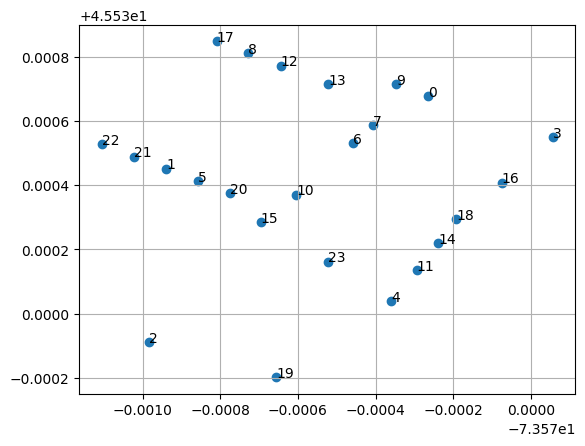

In [23]:
# create graph
G=nx.Graph()
for i in range(len(centroid)):
    G.add_node(i,pos=(centroid[i].x,centroid[i].y))
nx.draw(G, with_labels=True)

# extract position attributes of the points
pos=nx.get_node_attributes(G,'pos')

xs,ys,label=[],[],[]
for i in range(len(pos)):
    xs.append(pos[i][0])
    ys.append(pos[i][1])
    label.append(i)

# plot the centroids - plt

n=list(G.nodes)
fig, ax = plt.subplots()
ax.scatter(xs, ys)
plt.grid()

for i, txt in enumerate(n):
    ax.annotate(txt, (xs[i], ys[i]))
plt.show()

# plot the centroids - plotly
import plotly.express as px
px.scatter(x=xs,y=ys,width=1200, height=800,text=label)

## add one node representing "outside" and replot

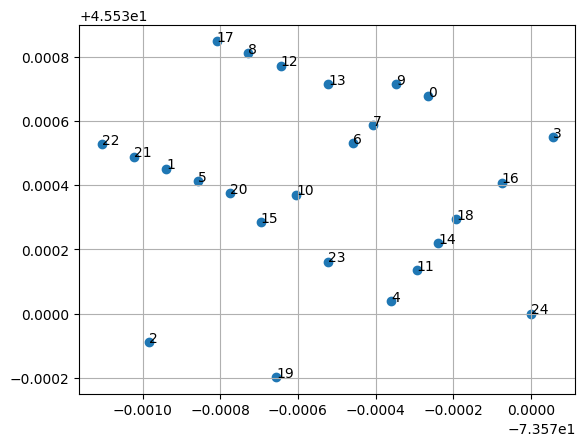

In [24]:
G.add_node(len(G),pos=(-73.57,45.53))
pos=nx.get_node_attributes(G,'pos')

xs,ys,label=[],[],[]
for i in range(len(pos)):
    xs.append(pos[i][0])
    ys.append(pos[i][1])
    label.append(i)

# plot the centroids - plt

n=list(G.nodes)
fig, ax = plt.subplots()
ax.scatter(xs, ys)
plt.grid()

for i, txt in enumerate(n):
    ax.annotate(txt, (xs[i], ys[i]))
plt.show()

# plot the centroids - plotly
import plotly.express as px
px.scatter(x=xs,y=ys,width=1200, height=800,text=label)

## connecting all the nodes to the "outside" node

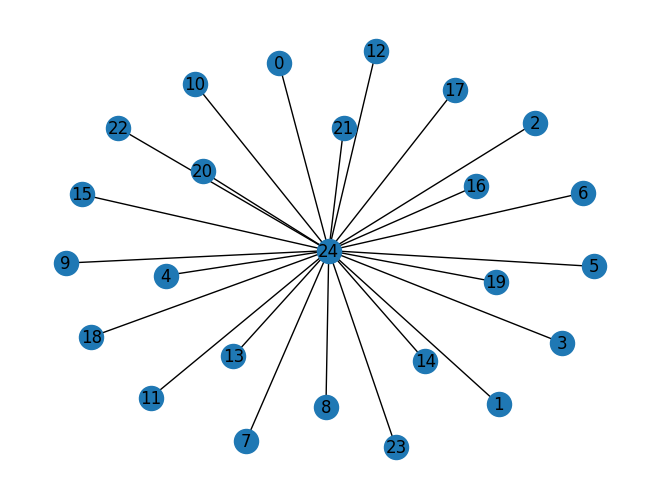

In [25]:
N=len(G)-1
for i in range(len(G)-1):
    G.add_edge(i, N)
G.number_of_edges()
nx.draw(G, with_labels=True)


### The graph is created and can be used in the MESA space definition

# ABM Setup

In [26]:
import mesa
import random


## model and agents are set up such that their initial positions are their homes, which share the same ID as the agents. Their movement from and to home in each step depends on a randomly generated integer

In [30]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
        self.home=self.unique_id

    def move_out(self):
        new_position = 24
        self.model.grid.move_agent(self, new_position)
    
    def go_home(self):
        self.model.grid.move_agent(self,self.home)
    
    # def give_money(self):
    #     cellmates = self.model.grid.get_cell_list_contents([self.pos])
    #     if len(cellmates) > 1:
    #         other = self.random.choice(cellmates)
    #         other.wealth += 1
    #         self.wealth -= 1



    def step(self):
        if self.pos==self.home:
            if random.randint(0,10)>8:
                self.move_out()
        else:
            if random.randint(0,10)>8:
                self.go_home()
        
        # The agent's step will go here.
        # For demonstration purposes we will print the agent's unique_id
        print("Agent #" + str(self.unique_id) + ", Wealth:"+str(self.wealth)+",Location:"+str(self.pos))
        # if self.wealth > 0:
        #     self.give_money()

class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N):
        self.num_agents = N
        # self.grid = mesa.space.MultiGrid(width, height, True)
        self.grid = mesa.space.NetworkGrid(G)
        self.schedule = mesa.time.RandomActivation(self)
        self.running = True
        
        # Create agents
        for i, node in enumerate(list(G.nodes())[:-1]):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
            # Add the agent to a random grid cell
            # x = self.random.randrange(self.grid.width)
            # y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a,node)

        self.datacollector = mesa.DataCollector(
             agent_reporters={"pos": "pos",}
        )

    def step(self):
        """Advance the model by one step."""
        self.datacollector.collect(self)
        self.schedule.step()

## having defined the model and agents, 24 agents (same number as the number of nodes (=buildings)) are created and ten (10) ticks are performed. 

In [47]:
model = MoneyModel(len(centroid))
for i in range(10):
    model.step()

Agent #2, Wealth:1,Location:2
Agent #6, Wealth:1,Location:24
Agent #21, Wealth:1,Location:21
Agent #18, Wealth:1,Location:18
Agent #9, Wealth:1,Location:24
Agent #19, Wealth:1,Location:24
Agent #12, Wealth:1,Location:12
Agent #22, Wealth:1,Location:24
Agent #3, Wealth:1,Location:3
Agent #23, Wealth:1,Location:24
Agent #11, Wealth:1,Location:11
Agent #15, Wealth:1,Location:15
Agent #0, Wealth:1,Location:0
Agent #7, Wealth:1,Location:7
Agent #4, Wealth:1,Location:4
Agent #8, Wealth:1,Location:8
Agent #14, Wealth:1,Location:24
Agent #16, Wealth:1,Location:16
Agent #1, Wealth:1,Location:1
Agent #17, Wealth:1,Location:17
Agent #13, Wealth:1,Location:13
Agent #10, Wealth:1,Location:10
Agent #20, Wealth:1,Location:20
Agent #5, Wealth:1,Location:5
Agent #8, Wealth:1,Location:8
Agent #23, Wealth:1,Location:23
Agent #3, Wealth:1,Location:3
Agent #20, Wealth:1,Location:20
Agent #11, Wealth:1,Location:11
Agent #16, Wealth:1,Location:16
Agent #0, Wealth:1,Location:0
Agent #13, Wealth:1,Location:24


## history of agents positions can be queried from the datacollector module, as follows.

In [48]:
agent_pos = model.datacollector.get_agent_vars_dataframe()
agent_pos

pos
Step AgentID     
0    0          0
     1          1
     2          2
     3          3
     4          4
...           ...
9    19        24
     20        24
     21        24
     22        22
     23        24

[240 rows x 1 columns]

## history of agents positions can be plotted as follows.

<AxesSubplot: xlabel='Step'>

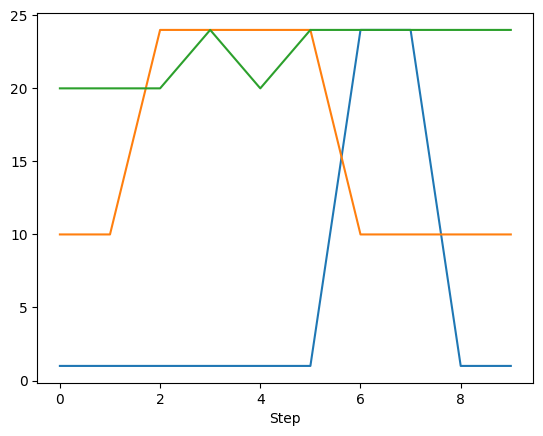

In [49]:
Agent_ID=1
one_agent_wealth = agent_pos .xs(Agent_ID, level="AgentID")
one_agent_wealth.pos.plot()

Agent_ID=10
one_agent_wealth = agent_pos .xs(Agent_ID, level="AgentID")
one_agent_wealth.pos.plot()

Agent_ID=20
one_agent_wealth = agent_pos .xs(Agent_ID, level="AgentID")
one_agent_wealth.pos.plot()